### Import trained model
Run `nvidia-smi -l 1` to check the memory being used by what.
You will need to restart the kernel if the program is crashing as jupyter stays allive and keeps the data in the memory.

In [4]:
import pickle
import keras
import librosa
import librosa.display
import numpy as np
from sklearn import metrics

sound_model_file = "sound_model.pkl"
label_encoder_file = "labelencoder.pkl"

with tf.device('/gpu:0'):
    model = None

    with open(sound_model_file, 'rb') as file:
        model = pickle.load(file)

    with open(label_encoder_file, 'rb') as file:
        le = pickle.load(file)

%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
#%store -r model 
#%store -r le
%store -r X
%store -r y

In [2]:
usl = "../resources/UrbanSound8K/"

In [3]:

num_rows = 40
num_columns = 174
num_channels = 1

max_pad_len = 174

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

6686/6686 [==============================] - 1s 179us/step
Training Accuracy:  0.9925217032432556
1672/1672 [==============================] - 0s 70us/step
Testing Accuracy:  0.9312201142311096


In [10]:
def prediction(file_name, print_data = False):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector)
    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    if print_data:
        print("The predicted class is:", predicted_class[0], '\n') 
        
        for i in range(len(predicted_proba)): 
            category = le.inverse_transform(np.array([i]))
            print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )
    return (predicted_class[0], format(predicted_proba[predicted_vector[0]] * 100, '.32f'))

In [11]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name, e)
        return None 
     
    return mfccs

In [12]:
# Class: Air Conditioner

filename = usl + 'audio/fold5/100852-0-0-0.wav' 
prediction(filename, True) 

The predicted class is: air_conditioner 

air_conditioner 		 :  0.99995946884155273437500000000000
car_horn 		 :  0.00000000000429289676723287882965
children_playing 		 :  0.00000133125183765514520928263664
dog_bark 		 :  0.00000000154084023318290519455331
drilling 		 :  0.00000701597036822931841015815735
engine_idling 		 :  0.00000061863573819209705106914043
jackhammer 		 :  0.00002545975439716130495071411133
siren 		 :  0.00000046361785166482150088995695
street_music 		 :  0.00000557679868506966158747673035


('air_conditioner', '99.99594688415527343750000000000000')

In [13]:
predictions = model.predict(x_test)
y_pred = (predictions > 0.5)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

### Checking data from testing for more info

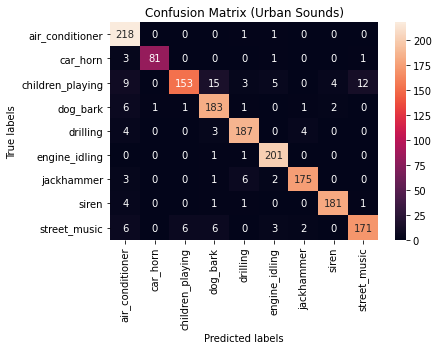

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

label_names = le.classes_

plt.figure()
ax= plt.subplot(111)
sns.heatmap(matrix, annot=True, ax = ax, fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (Urban Sounds)')
ax.xaxis.set_ticklabels(label_names, rotation='vertical');
ax.yaxis.set_ticklabels(label_names, rotation='horizontal');

plt.show()

### Test with sounds from odas

In [21]:
from os import listdir
from os.path import isfile, join

odas_clips = "/home/sekwah/Music/"

sound_files = [f for f in listdir(odas_clips) if isfile(join(odas_clips, f))]

#print(sound_files)

for file in sound_files:
    try:
        predict = prediction(join(odas_clips, file), False)
        print("{} {}% {}".format(predict[0], predict[1], file))
    except:
        print("Error reading file: " + join(odas_clips, file))

Error encountered while parsing file:  /home/sekwah/Music/ODAS_1_2020-4-23_19-20-44-24_sp.wav index can't contain negative values
Error reading file: /home/sekwah/Music/ODAS_1_2020-4-23_19-20-44-24_sp.wav
dog_bark 92.21527576446533203125000000000000% ODAS_1_2020-4-23_19-20-44-24_11_pf.wav
dog_bark 81.00326061248779296875000000000000% ODAS_1_2020-4-23_19-20-44-24_12_pf.wav
dog_bark 99.18701648712158203125000000000000% ODAS_1_2020-4-23_19-20-44-24_13_pf.wav
car_horn 99.94770884513854980468750000000000% ODAS_1_2020-4-23_19-20-44-24_3_pf.wav
car_horn 77.64003872871398925781250000000000% ODAS_1_2020-4-23_19-20-44-24_8_pf.wav
car_horn 96.04970812797546386718750000000000% ODAS_1_2020-4-23_19-20-44-24_2_pf.wav
dog_bark 93.51277947425842285156250000000000% ODAS_1_2020-4-23_19-20-44-24_10_pf.wav
car_horn 65.30088782310485839843750000000000% ODAS_1_2020-4-23_19-20-44-24_7_pf.wav
car_horn 76.84741020202636718750000000000000% ODAS_1_2020-4-23_19-20-44-24_pf.wav
car_horn 85.4661107063293457031250000

### Export to allow better use of models

In [5]:
model.save('sound_category_model.h5')